# Wykrywanie fraudów transakcji na kartach płatniczych

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import sklearn.metrics as sm
get_ipython().magic('matplotlib inline')

In [2]:
os.chdir('.../Anomalie')
df = pd.read_csv("creditcard.csv")

In [ ]:
#df.hist(bins=100, figsize=(12,12))
#df.head()
print(df.describe())

In [4]:
y = df['Class']; X = df
X.drop(['Class', 'Time'], axis=1, inplace=True)

In [5]:
print(X.shape, y.sum())

(284807, 29) 492


In [6]:
def performance(y, labels):
    print(' Recall:', round(sm.recall_score(y, labels), 4), '\n Precision:', round(sm.precision_score(y, labels), 4),
        '\n Accuracy:', round(sm.accuracy_score(y, labels), 4))

Redukcja wymiarów

In [51]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA

srp = SparseRandomProjection(n_components=2)
pca = PCA(n_components=3)

X_reduced_srp = srp.fit_transform(X)
X_reduced = pca.fit_transform(X)
X_reduced = np.insert(X_reduced, 3, X_reduced[:,2] / X_reduced[:,1], axis=1)

Text(0.5,0,'V2')

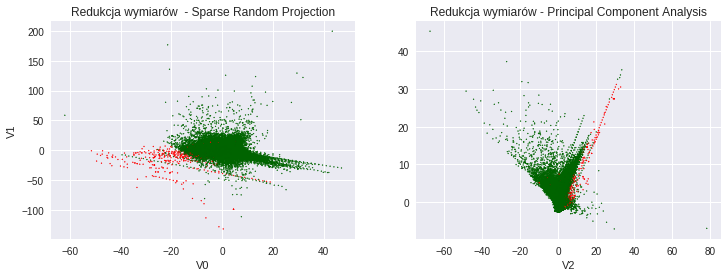

In [52]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter( X_reduced_srp[:,0], X_reduced_srp[:,1], c=y, s=1, cmap=ListedColormap(['#006400', '#ff0000']))
plt.title('Redukcja wymiarów  - Sparse Random Projection'); plt.ylabel('V1'); plt.xlabel('V0')

plt.subplot(1, 2, 2)
plt.scatter( X_reduced[:,2], X_reduced[:,1], c=y, s=1, cmap=ListedColormap(['#006400', '#ff0000']))
plt.title('Redukcja wymiarów - Principal Component Analysis'); plt.xlabel('V2')

Wykrywanie outlierów

In [53]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=20, max_samples='auto', contamination=0.015) 

labels = clf.fit_predict(X_reduced[:,1:3])
labels[labels==1] = 0
labels[labels==-1] = 1
labels[labels==1].sum()

/home/sas/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/home/sas/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/iforest.py:418: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


4235

In [80]:
performance(y, labels)

 Recall: 0.3516 
 Precision: 0.0409 
 Accuracy: 0.9846


In [81]:
# Odcięcie "lewego ucha" klasyfikacji - poprawi precyzję
labels2 = (X_reduced[:,3] > 1.0) * labels .astype('int')
performance(y, labels2)

 Recall: 0.2805 
 Precision: 0.3033 
 Accuracy: 0.9976


In [82]:
xx, yy = np.meshgrid(np.linspace(-80, 90, 50), np.linspace(-10, 50, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Text(0.5,0,'V2')

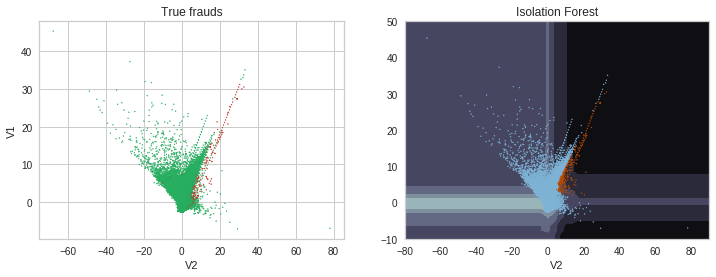

In [83]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter( X_reduced[:,2], X_reduced[:,1], c=y, s=1, cmap=ListedColormap(['#27AE60', '#C0392B']))
plt.title('True frauds'); plt.ylabel('V1'); plt.xlabel('V2')

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, cmap=plt.cm.bone)
plt.scatter( X_reduced[:,2], X_reduced[:,1], c=labels2, s=1, cmap=ListedColormap(['#7FB3D5', '#BA4A00']))
plt.title('Isolation Forest'); plt.xlabel('V2')

In [85]:
from sklearn.covariance import EllipticEnvelope

clf = EllipticEnvelope(contamination=0.015)

labels = clf.fit_predict(X_reduced[:,1:3])
labels[labels==1] = 0
labels[labels==-1] = 1
labels[labels==1].sum()

4273

In [86]:
performance(y, labels)

 Recall: 0.4573 
 Precision: 0.0527 
 Accuracy: 0.9848


In [87]:
# Odcięcie "lewego ucha" klasyfikacji - poprawi precyzję
labels2 = (X_reduced[:,3] > 1.0) * labels .astype('int')
performance(y, labels2)

 Recall: 0.3821 
 Precision: 0.3047 
 Accuracy: 0.9974


In [88]:
xx, yy = np.meshgrid(np.linspace(-80, 90, 50), np.linspace(-10, 50, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Text(0.5,0,'V2')

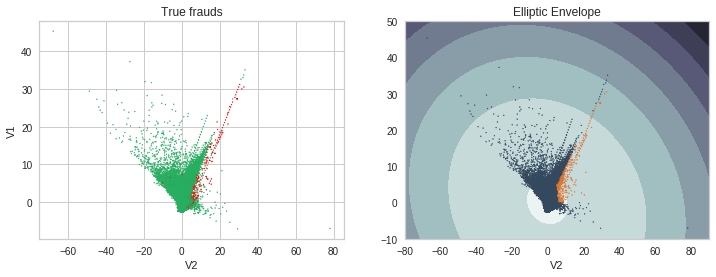

In [89]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter( X_reduced[:,2], X_reduced[:,1], c=y, s=1, cmap=ListedColormap(['#27AE60', '#FF0000']))
plt.title('True frauds'); plt.ylabel('V1'); plt.xlabel('V2')

plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, cmap=plt.cm.bone)
plt.scatter( X_reduced[:,2], X_reduced[:,1], c=labels2, s=1, cmap=ListedColormap(['#34495E', '#DC7633']))
plt.title('Elliptic Envelope'); plt.xlabel('V2')

Klasyfikacja siecią neuronową

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.sum(), y_test.sum())

(213605, 29) (71202, 29) (213605,) (71202,)
379 113


In [ ]:
import tensorflow as tf

feature_cols = tf.contrib.learn.infer_real_valued_columns_from_input(X_train)
clf = tf.contrib.learn.DNNClassifier(hidden_units=[30,30,30], n_classes=2, feature_columns=feature_cols,
    activation_fn=tf.nn.elu, optimizer=tf.train.AdamOptimizer())

#GradientDescentOptimizer tf.train.AdamOptimizer() RMSPropOptimizer(learning_rate=0.01, momentum=0.9, decay=0.9) 
#AdagradOptimizer(learning_rate=0.01) MomentumOptimizer(learning_rate=0.01, momentum=0.9, use_nesterov=True)

In [ ]:
clf.fit(X_train, y_train, batch_size=60, steps=20000)
pred_ob = clf.predict(X_test)
pred = []
for e in pred_ob:
    pred.append(e)

In [98]:
performance(y_test, pred)

 Recall: 0.7955 
 Precision: 0.8678 
 Accuracy: 0.9994


Klasyfikacja fraudów

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  AdaBoostClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [29]:
clf = LogisticRegression(solver = 'warn', C=1000, max_iter=200).fit(X_train, y_train)
pred0 = clf.predict(X_test)

performance(y_test, pred0)

/home/sas/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 Recall: 0.7611 
 Precision: 0.86 
 Accuracy: 0.9994


In [32]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=8).fit(X_train, y_train)
pred1 = clf.predict(X_test)

performance(y_test, pred1)

 Recall: 0.8142 
 Precision: 0.8519 
 Accuracy: 0.9995


In [11]:
clf = XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=30).fit(X_train, y_train)
pred2 = clf.predict(X_test)

performance(y_test, pred2)

 Recall: 0.8496 
 Precision: 0.8727 
 Accuracy: 0.9996


In [113]:
clf = CatBoostClassifier(learning_rate=0.1, depth=8, iterations=100, verbose=False).fit(X_train, y_train)
pred3 = clf.predict(X_test)

performance(y_test, pred3)

 Recall: 0.8333 
 Precision: 0.9402 
 Accuracy: 0.9996


In [111]:
clf = AdaBoostClassifier(
    DecisionTreeClassifier(criterion='gini', max_depth=8), n_estimators=20, learning_rate=0.5).fit(X_train, y_train)
pred4 = clf.predict(X_test)

performance(y_test, pred4)

 Recall: 0.8333 
 Precision: 0.9565 
 Accuracy: 0.9996


Wizualizacja klasyfikacji najlepszego algorytmu

In [34]:
pca = PCA(n_components=3)
X_reduced_test = pca.fit_transform(X_test)

Text(0.5,0,'V2')

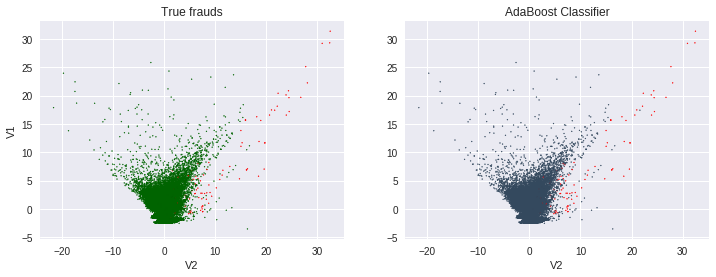

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.scatter( X_reduced_test[:,2], X_reduced_test[:,1], c=y_test, s=1, cmap=ListedColormap(['#006400', '#FF0000']))
plt.title('True frauds'); plt.ylabel('V1'); plt.xlabel('V2')

plt.subplot(1, 2, 2)
plt.scatter( X_reduced_test[:,2], X_reduced_test[:,1], c=pred4, s=1, cmap=ListedColormap(['#34495E', '#FF0000']))
plt.title('AdaBoost Classifier'); plt.xlabel('V2')